<a href="https://colab.research.google.com/github/cjfghk5697/LG-CNS/blob/main/7%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q&A 만들기

# 데이터셋

In [ ]:
!pip3 install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24

In [ ]:
from datasets import get_dataset_config_names

domains=get_dataset_config_names('subjqa')
domains

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for subjqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/subjqa.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [ ]:
from datasets import load_dataset
subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

In [ ]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [ ]:
import pandas as pd
dfs={split: dset.to_pandas() for split, dset in subjqa.flatten().items()}#flatten() 메서드로 중첩된 열을 펼침
for split, df in dfs.items():
  print(f"{split}에 있는 질문 개수: {df['id'].nunique()}")

train에 있는 질문 개수: 1295
test에 있는 질문 개수: 358
validation에 있는 질문 개수: 255


In [ ]:
dfs

{'train':            domain       nn_mod         nn_asp   query_mod   query_asp  \
 0     electronics        great  bass response   excellent        bass   
 1     electronics        harsh           high  not strong        bass   
 2     electronics      neutral          sound     present        bass   
 3     electronics        muddy           bass     awesome        bass   
 4     electronics      perfect           bass  incredible       sound   
 ...           ...          ...            ...         ...         ...   
 1290  electronics        great     impression     rubbery        feel   
 1291  electronics        tight           case       great  protection   
 1292  electronics         good        texture        good        grip   
 1293  electronics  easy to use       keyboard   removable    keyboard   
 1294  electronics  easy to use       keyboard   removable    keyboard   
 
                           q_reviews_id  question_subj_level  ques_subj_score  \
 0     0514ee34b6726

In [ ]:
qa_cols=["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df=dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


데이터셋 샘플에 특징은 문법적으로 바르지 않고, 리뷰에서 답을 찾지 못해 답변이 불가한 경우가 있음. 마지막으로 시작인덱스와 답변 길이를 이용해 답변에 해당하는 텍스트를 추출할 수 있음.

In [ ]:
start_idx=sample_df["answers.answer_start"].iloc[0][0]
end_idx=start_idx+len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

# 텍스트에서 답 추출하기

답변에 사용할 만한 부분을 식별해낼 방법을 찾아야함.이를 위해 아래 방법을 이해해야함.

* 지도학습 문제로 구성하기
* QA 작업을 위해 텍스트를 토큰화하고 인코딩하기
* 모델의 최대 문맥 크기를 초과하는 긴 텍스트 다루기

### 범위 분류 작업
텍스트에서 답을 추출하는 가장 일반적인 방법임. 이 작업에에서 모델이 예측해야하는 레이블은 답변 범위에 해당하는 시작 토큰과 종료 토큰임.

우리가 쓰는 데이터셋은 부족하기에 SQuAD 같은 대규모 QA 데이터셋을 학습한 모델을 가져와 transfer learning할 예정임.

In [ ]:
# QA를 위한 텍스트 토큰화
from transformers import AutoTokenizer
model_ckpt="deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
question="How much music can this hold?"
context="""An MP3 is about 1MB/minute, so about 6000 hours depending on file size."""
inputs=tokenizer(question, context, return_tensors="pt")

In [ ]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 14905,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [ ]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1mb / minute, so about 6000 hours depending on file size. [SEP]


In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering
model=AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
  outputs=model(**inputs)
print(outputs)

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-1.1224, -4.7834, -5.3935, -5.2447, -5.2899, -5.4980, -4.9885, -6.1783,
         -1.1224,  0.3651, -0.0807, -1.5551,  3.9556,  4.9206, -2.7833, -3.7461,
         -1.7211, -4.6096, -1.3769,  4.0256,  4.9715, -0.2477, -3.0354, -4.8180,
         -2.2386, -3.4867, -3.5462, -1.1224]]), end_logits=tensor([[-1.0707, -5.4841, -5.0304, -5.1770, -5.4496, -5.5120, -5.2013, -4.6178,
         -1.0707, -3.7223, -0.7583, -3.6969, -2.9205, -1.7346,  0.3122, -2.8688,
          4.8807,  0.2692, -3.1317, -3.2404,  0.8239,  5.6645, -0.2568, -4.8910,
         -3.1677, -0.0130,  1.6739, -1.0707]]), hidden_states=None, attentions=None)


In [ ]:
start_logits=outputs.start_logits
end_logits=outputs.end_logits

In [ ]:
print(f"입력 ID 크기: {inputs.input_ids.size()}")
print(f"시작 로짓 크기: {start_logits.size()}")
print(f"종료 로짓 크기: {end_logits.size()}")

입력 ID 크기: torch.Size([1, 28])
시작 로짓 크기: torch.Size([1, 28])
종료 로짓 크기: torch.Size([1, 28])


In [ ]:
start_logits

tensor([[-1.1224, -4.7834, -5.3935, -5.2447, -5.2899, -5.4980, -4.9885, -6.1783,
         -1.1224,  0.3651, -0.0807, -1.5551,  3.9556,  4.9206, -2.7833, -3.7461,
         -1.7211, -4.6096, -1.3769,  4.0256,  4.9715, -0.2477, -3.0354, -4.8180,
         -2.2386, -3.4867, -3.5462, -1.1224]])

In [ ]:
# 최종답을 얻기위해 argmax 함수를 적용하고 입력에서 이 범위를 슬라이싱함.
import torch

start_idx=torch.argmax(start_logits)
end_idx=torch.argmax(end_logits)+1
answer_span=inputs["input_ids"][0][start_idx:end_idx]
answer=tokenizer.decode(answer_span)
print(f"질문: {question}")
print(f"답변: {answer}")

질문: How much music can this hold?
답변: 6000 hours


In [ ]:
# 위에서 한 모든 것들이 transformers 파이프라인에 더 넣어서 처리 가능함. 그리고 score를 알렺ㅁ
from transformers import pipeline
pipe=pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2436027228832245, 'start': 37, 'end': 47, 'answer': '6000 hours'},
 {'score': 0.23150841891765594,
  'start': 16,
  'end': 47,
  'answer': '1MB/minute, so about 6000 hours'},
 {'score': 0.10571712255477905,
  'start': 16,
  'end': 26,
  'answer': '1MB/minute'}]

In [ ]:
pipe(question="Why is there no data?", context=context, hadle_impossible_answer=True)

{'score': 0.00033265299862250686,
 'start': 10,
 'end': 70,
 'answer': 'about 1MB/minute, so about 6000 hours depending on file size'}

최대 시퀸스 길이를 초과하는 긴텍스트가 들어올때가 있다. 텍스트 분류 같은 그외 작업에서는 정확한 예측을 생성하기 위해 [CLS] 토큰 임베딩에 충분하 정보가 담겼다고 가정하고 그냥 긴 텍스트를 잘랐음. 하지만 QA 작업에서는 이런 전략이 문제를 일으킴. 왜냐하면 질문의 답이 문맥의 끝에 있다면 같이 잘리기 때문임.

그래서 **슬라이싱 윈도**를 적용함. tokenizer에 return_overflowing_tokens=True로 설정해 슬라이싱 윈도를 설정함.

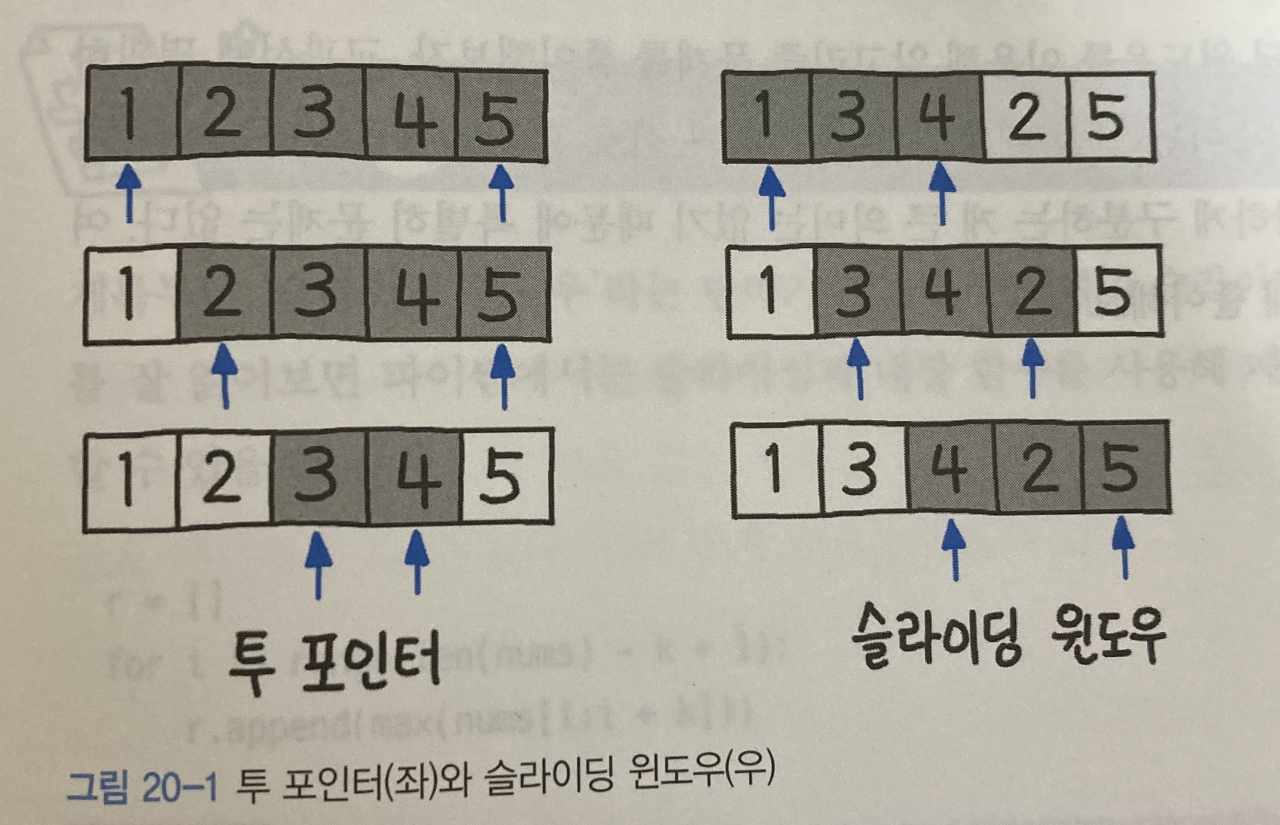

In [ ]:
example=dfs["train"].iloc[0][["question", "context"]]
tokenized_example=tokenizer(example["question"], example["context"],
                                    return_overflowing_tokens=True, max_length=100, #슬라이딩 윈도우
                            stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
for idx, window in enumerate(tokenized_example["input_ids"]):
  print(f"{idx} 윈도에는 {len(window)}개의 토큰이 있습니다.")

0 윈도에는 100개의 토큰이 있습니다.
1 윈도에는 88개의 토큰이 있습니다.


In [ ]:
for window in tokenized_example["input_ids"]:
  print(f"{tokenizer.decode(window)}\n")

# 두 decode 결과에서 첫번째 마지막쯤에 and don't feel heavy부터 겹침을 알수 있다. 보면 겹치는 부분은 stride 길이 25토큰이다.

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP]



# 헤이스택을 사용해 QA 파이프라인 구축하기
앞서 QA 모두 모델에 제공했음. 하지만 시스템의 실제 사용자는 질문만 제공함. 그래서 말뭉치에 있는 전체 리뷰 중 관련된 텍스트를 선택할 방법이 필요함. 이 방법은 간단하지만 문맥이 극도로 길어져 때로는 사용자 쿼리에 대한 레이턴시를 수용하지 못함.

각 리뷰마다 100미릴초가 걸리면 30개 리뷰를 처리하는데 3초의 레이턴시가 발생함. 인터넷에서는 너무 긴 시간임.

### 리트리버
그래서 최신 QA 시스템은 리트리버-리더 구조를 기반으로 이 문제를 처리함

* 리트리버

  쿼리에서 관련된 문서를 추출. 희소 아니면 밀집으로 구분하는데, 희소 리트리버는 단어 빈도를 사용해 각 무서와 쿼리를 희소 백터(sparse representation)로 표현. 그리고 내적을 계산해 쿼리와 문서의 관련성을 결정함.
  
  반면 밀집 리트리버는 트랜스포머 같은 인코더를 사용해 쿼리와 문서를 문맥화된 임베딩으로 표현. 이런 임베딩이 의미를 인코딩하여 밀집 리트리버는 쿼리의 내용을 이해해 검색 정확도를 향상시킴.

* 리더

  리트리버가 제공한 문서에서 답을 추출함.


이 QA 시스템은 딥셋이 개발한 헤이스택 라이브러리로 가능함.

<hr/>

헤이스택에서 사용가능한 문서 저장소가 다양한데, 그 중 ElasticsearchDocumentStore가 밀집과 희소 리트리버 양쪽 모두 호환됨. 이는 텍스트 서치 지리 데이터 구조적 데이터 비구조적 데이터를 포함해 다양한 데이터 타입을 처리하는 검색 엔진임. 대용량 데이터를 저장하고 전체 텍스트 검색으로 빠르게 필터링하므로 특히 QA 시스템 개발에 잘맞음.

In [ ]:
ㅈ

<tip>
너무 과한 다운로드 요청으로 인해 여기서 중지
</tip>